In [6]:
import tensorflow as tf
import numpy as np
import time
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from IcGanLayer import gan_loss, classify_loss, generator
from dataset_and_utils import prepare_datasets, show_image, list_devices, prepare_new_datasets, save_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
n_classes = 309
batch_size = 32
n_iters = 138661*10//batch_size

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement=True
config.allow_soft_placement=True

In [3]:
train_dataset, val_dataset, test_dataset = prepare_new_datasets(batch_size)

# step 4: create iterator and final input tensor
train_iterator = train_dataset.make_one_shot_iterator()
val_iterator = val_dataset.make_one_shot_iterator()


Duration is 0.04368400573730469
Duration is 0.012995004653930664
Duration is 0.011069536209106445


In [4]:
# tf.reset_default_graph()
with tf.device('/device:GPU:0'):
    x = tf.placeholder(tf.float32, shape=[None, 64, 64,  3], name='x')
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name='y')
    
    loss_pred, loss_gen, gen = gan_loss(x, y, n_classes)
    loss_cls, Ey = classify_loss(x, y, n_classes)
    
    evaluate = tf.equal(tf.round(Ey), y)
    accuracy = tf.reduce_mean(tf.cast(evaluate,dtype=tf.float32))
    
    saver = tf.train.Saver()
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        pred_optimizer = tf.train.AdamOptimizer(10e-6, beta1=0.5).minimize(loss_pred) #lr = 0.0002
        gen_optimizer = tf.train.AdamOptimizer(10e-6, beta1=0.5).minimize(loss_gen)
        cls_optimizer = tf.train.AdamOptimizer(10e-6, beta1=0.5).minimize(loss_cls)
    

Iter 5 0.0m:2.470548152923584s -- discriminator loss: 1.3606226444244385, generator loss: 0.46570584177970886


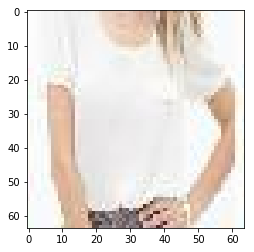

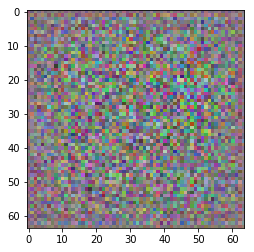

Iter 10 0.0m:7.60236120223999s -- discriminator loss: 1.3061953783035278, generator loss: 0.46915629506111145


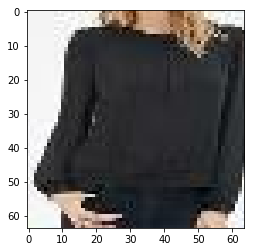

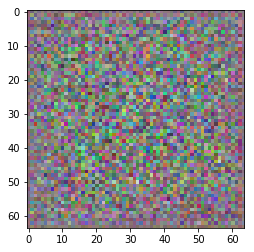

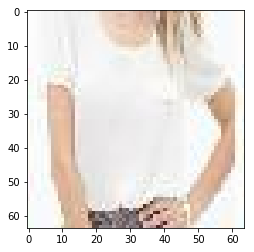

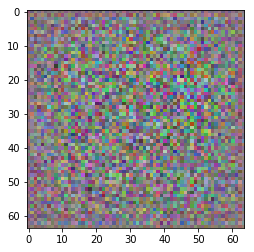

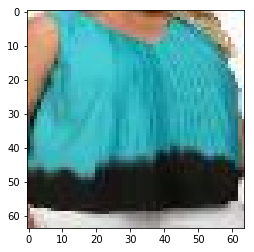

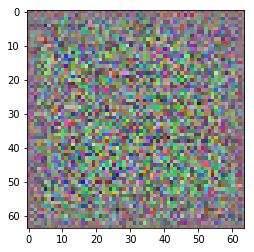

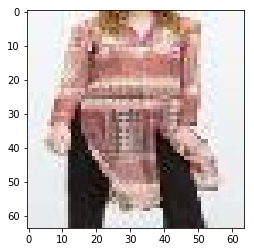

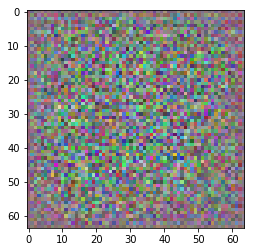

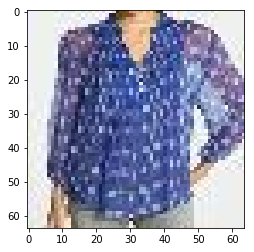

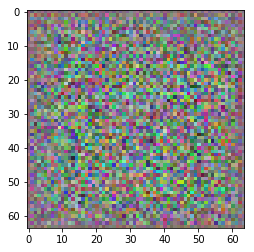

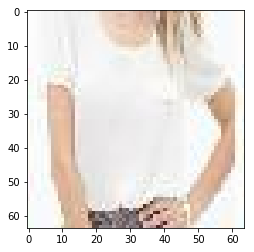

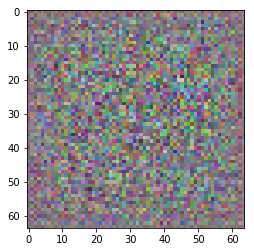

Iter 15 0.0m:13.165287256240845s -- discriminator loss: 1.3005940914154053, generator loss: 0.46932047605514526


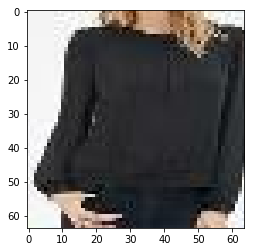

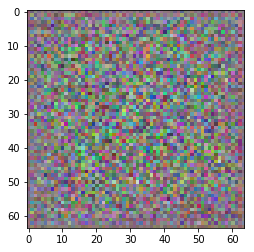

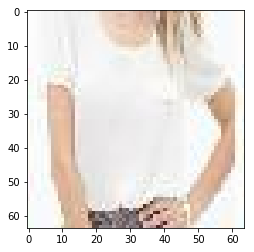

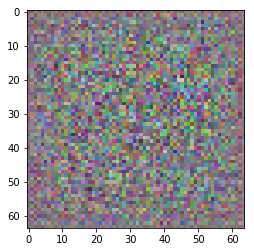

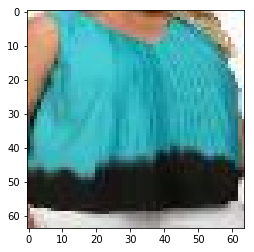

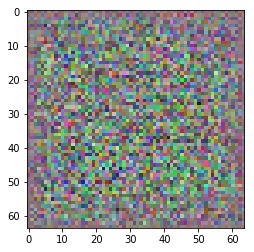

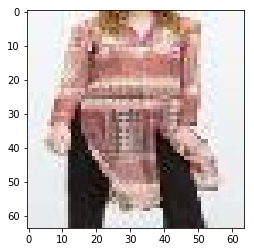

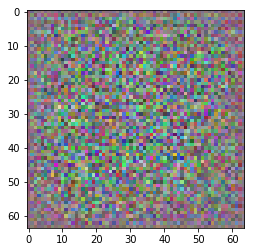

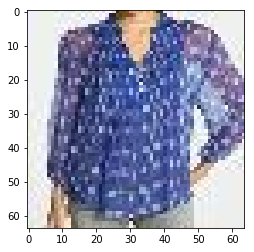

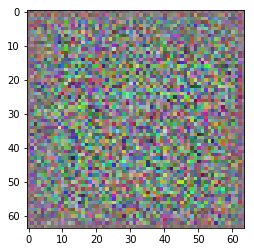

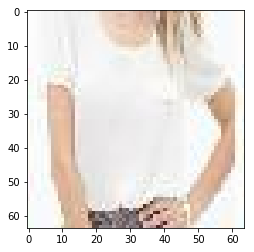

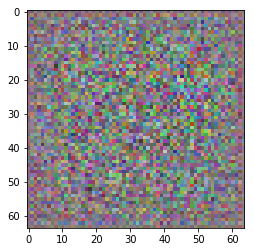

Iter 20 0.0m:18.13681149482727s -- discriminator loss: 1.298284649848938, generator loss: 0.4696081876754761


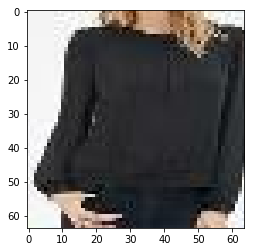

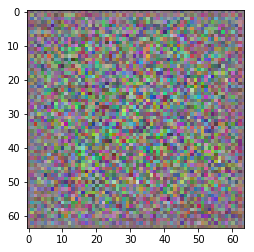

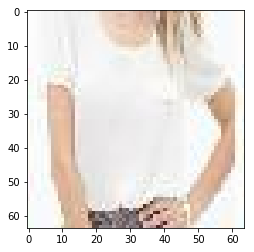

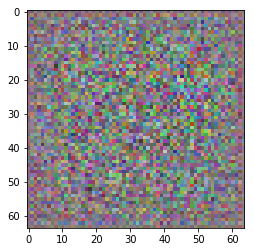

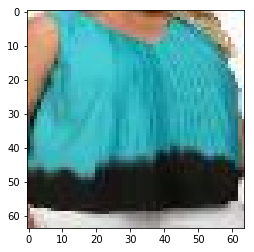

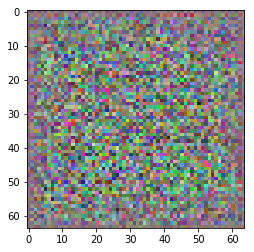

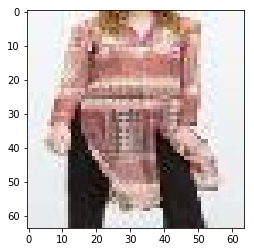

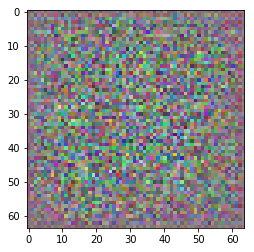

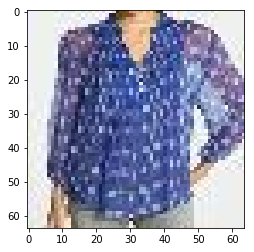

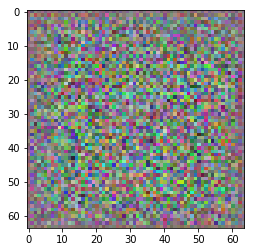

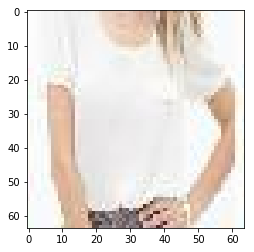

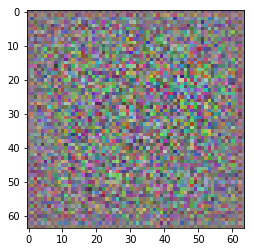

Iter 25 0.0m:23.27751326560974s -- discriminator loss: 1.2978367805480957, generator loss: 0.4693117141723633


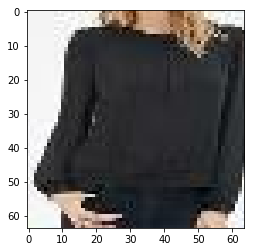

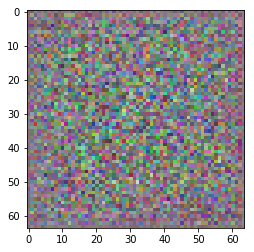

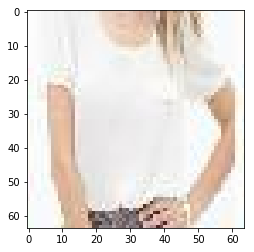

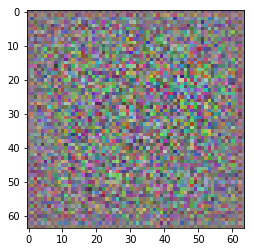

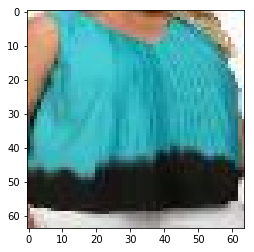

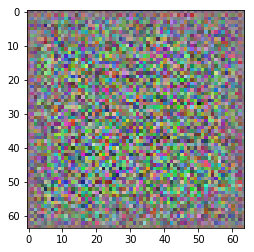

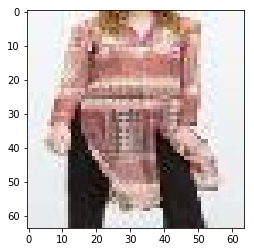

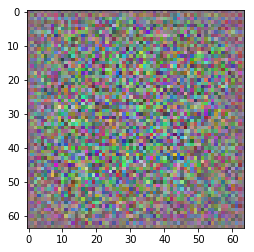

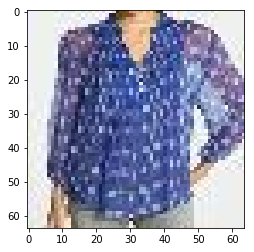

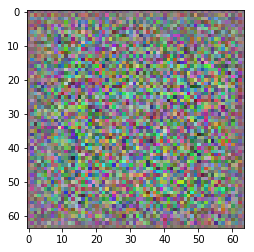

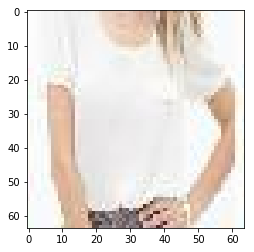

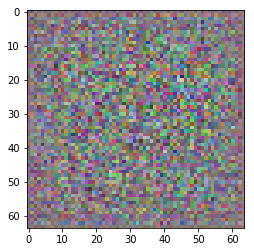

Iter 30 0.0m:28.56196880340576s -- discriminator loss: 1.2970560789108276, generator loss: 0.4694267511367798


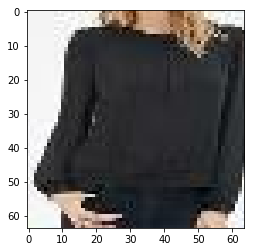

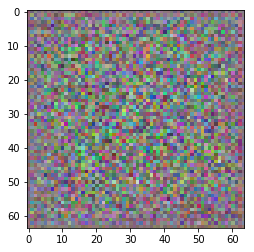

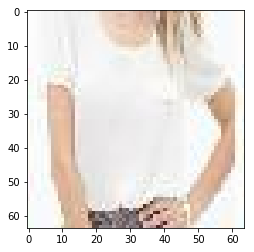

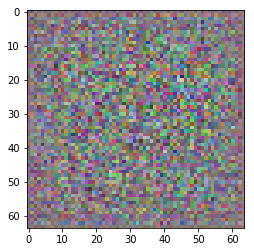

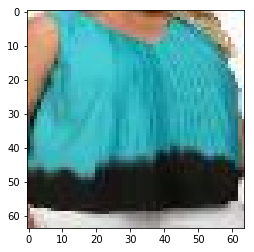

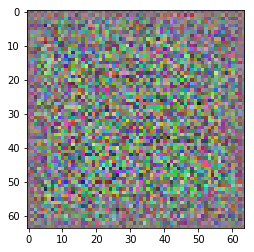

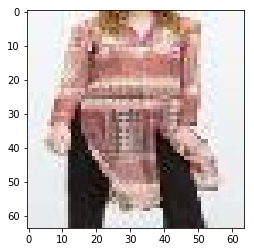

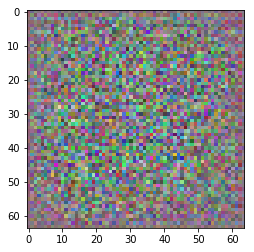

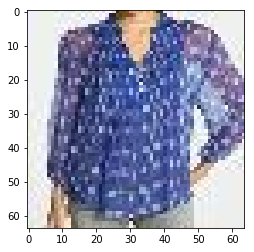

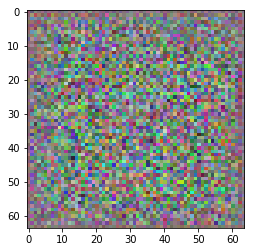

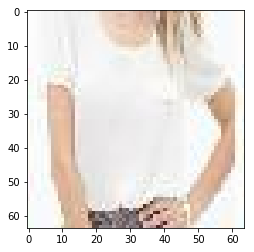

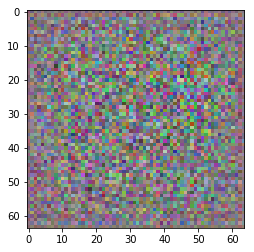

Iter 35 0.0m:34.03133988380432s -- discriminator loss: 1.2965614795684814, generator loss: 0.4694863259792328


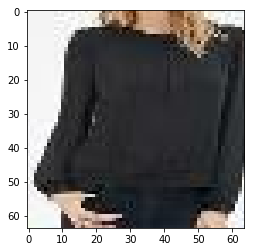

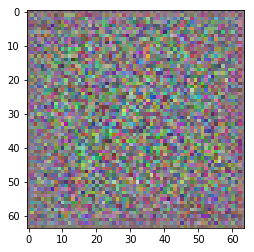

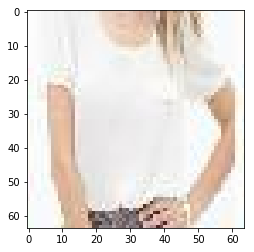

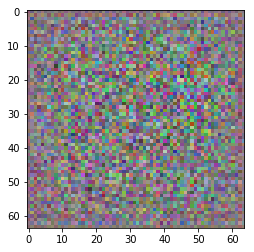

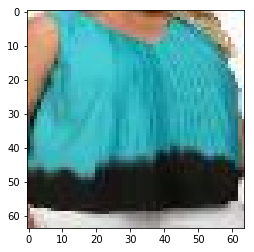

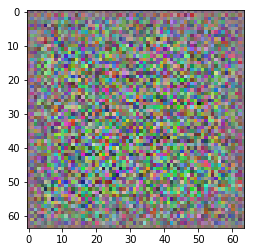

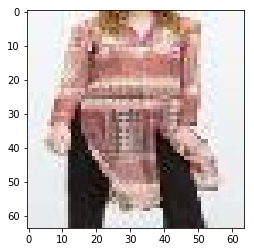

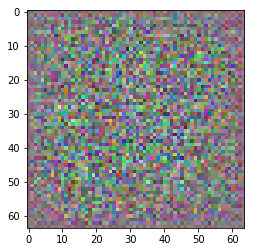

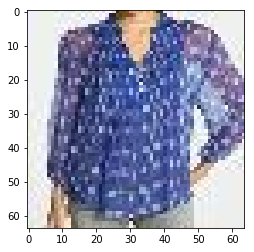

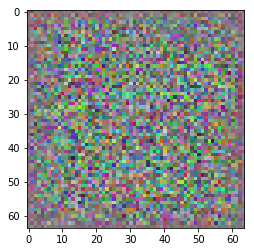

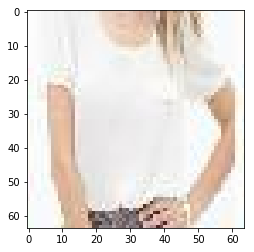

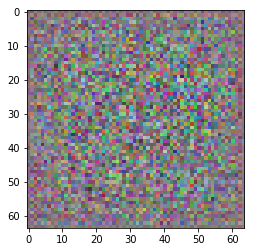

Iter 40 0.0m:39.32685160636902s -- discriminator loss: 1.2960116863250732, generator loss: 0.469643771648407


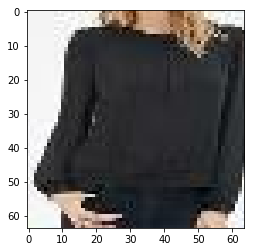

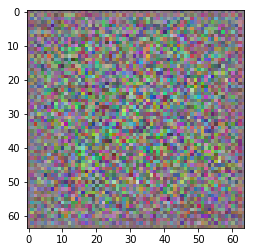

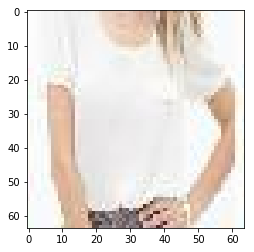

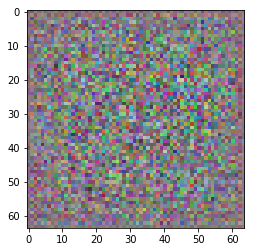

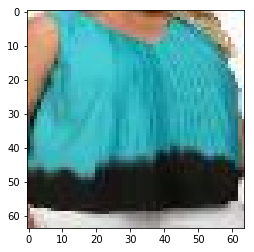

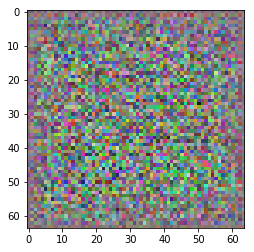

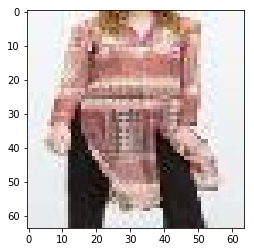

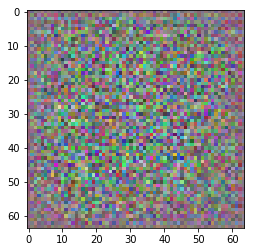

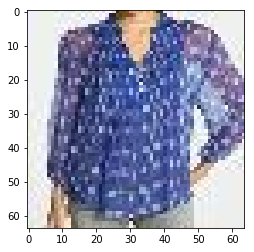

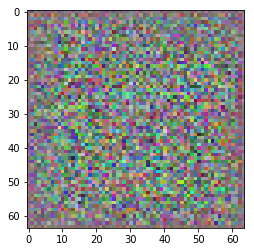

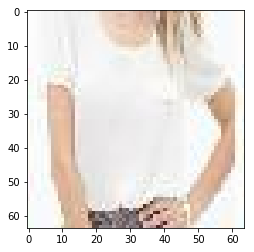

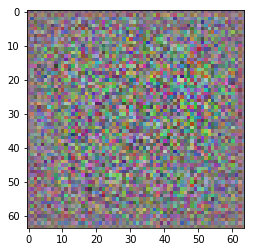

Iter 45 0.0m:45.21924161911011s -- discriminator loss: 1.2955933809280396, generator loss: 0.4697647988796234


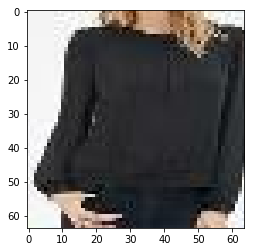

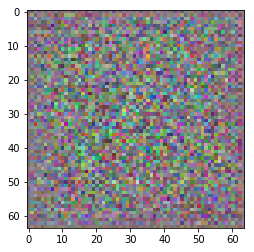

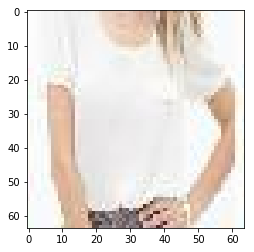

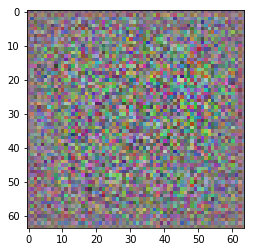

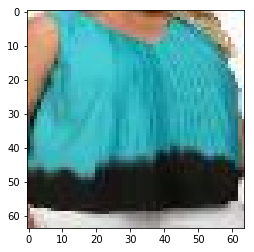

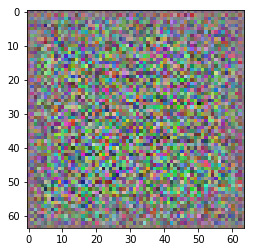

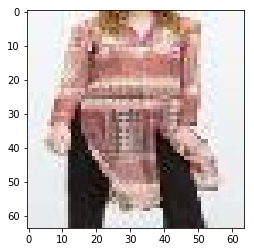

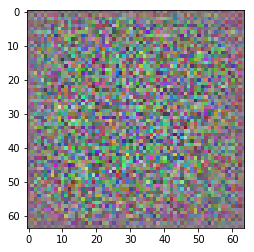

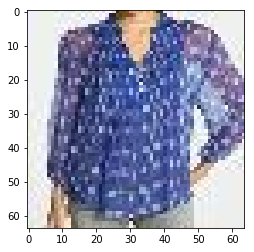

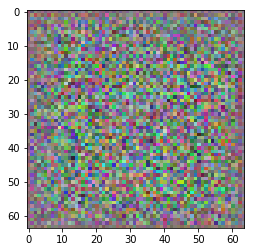

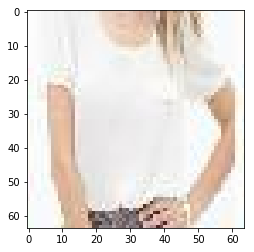

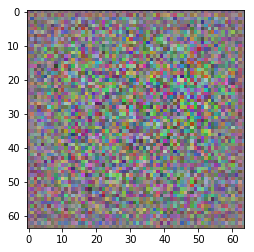

Iter 50 0.0m:50.678565979003906s -- discriminator loss: 1.295621395111084, generator loss: 0.46965476870536804


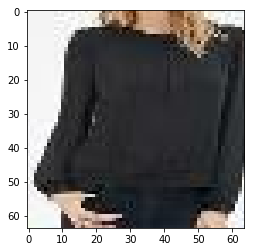

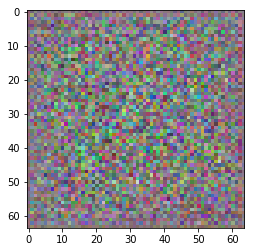

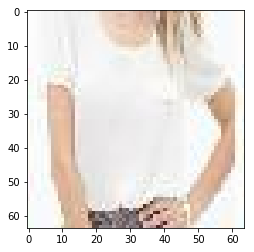

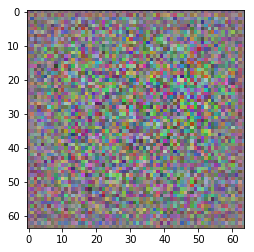

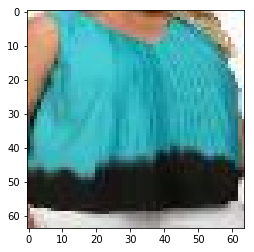

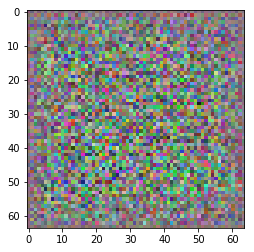

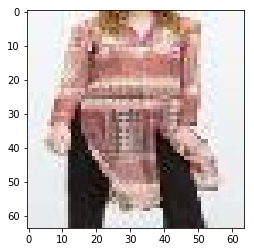

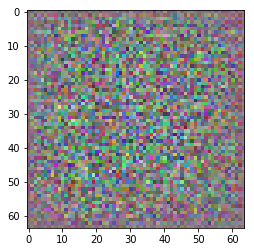

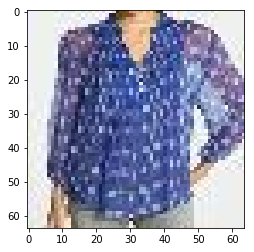

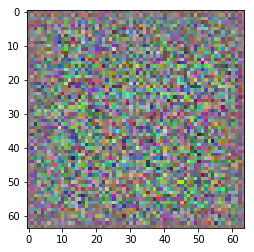

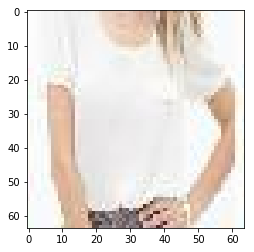

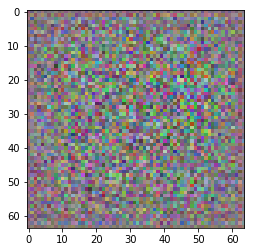

'model_10000/testmodel'

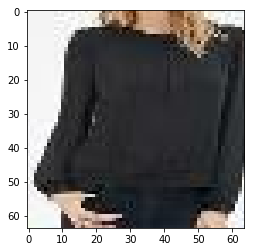

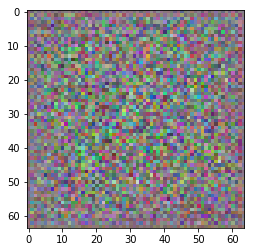

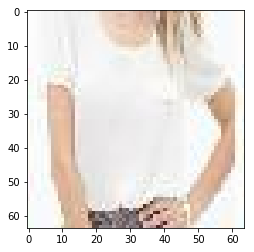

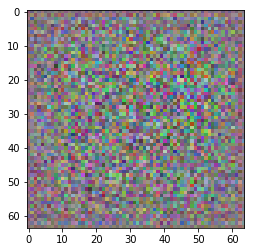

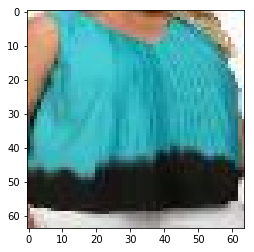

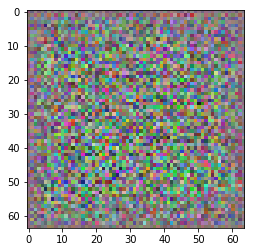

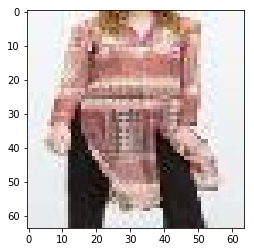

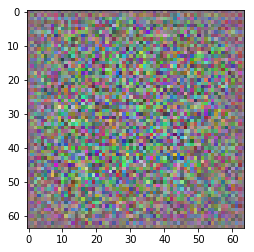

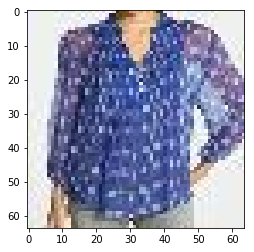

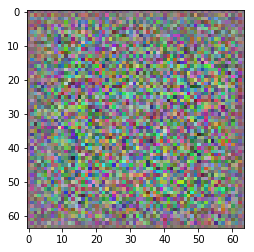

In [9]:
n_iters = 5000
print_every = 1000
test_every = 1000

#with tf.Session(config=config) as sess:
sess = tf.InteractiveSession(config=config)
init = tf.global_variables_initializer()
sess.run(init)


since = time.time()
for it in range(n_iters):
    try:
        imgs, labs = sess.run(train_iterator.get_next())
        if imgs.shape[0] != batch_size:
            raise Exception
    except:
        train_iterator = train_dataset.make_one_shot_iterator()
        imgs, labs = sess.run(train_iterator.get_next())
    _, _, pred_cost, gen_cost = sess.run([pred_optimizer, gen_optimizer, loss_pred, loss_gen], feed_dict={x:imgs, y:labs})

    if (it+1) % print_every == 0:
        uptime = time.time() - since
        print('Iter {} {}m:{}s -- discriminator loss: {}, generator loss: {}'.format(it+1, uptime//60, uptime%60,
                                                                           pred_cost, gen_cost))
        
    
    if (it+1) % test_every == 0:
        try:
            imgs, labs = sess.run(train_iterator.get_next())
            if imgs.shape[0] != batch_size:
                raise Exception
        except:
            train_iterator = train_dataset.make_one_shot_iterator()
            imgs, labs = sess.run(train_iterator.get_next())
            
#         try:
#             imgs, labs = sess.run(val_dataset.get_next())
#             if imgs.shape[0] != batch_size:
#                 raise Exception
#         except:
#             val_iterator = val_dataset.make_one_shot_iterator()
#             imgs, labs = sess.run(val_dataset.get_next())
            
        val_image = sess.run([gen], feed_dict={x:imgs, y:labs})

        show_image(imgs[1])
        val_image = np.array(val_image)
        show_image(np.squeeze(val_image)[1])
        img_dir = 'img_10000/training_{}'.format((it+1) // test_every)
        if not os.path.exists(img_dir):
            os.makedirs(img_dir)
        for i in range(5):
            save_image(imgs[i], img_dir+'/origin_{}'.format(i))
            save_image(np.squeeze(val_image)[i], img_dir+'/pred_{}'.format(i))
        saver.save(sess, 'model_10000/testmodel{}'.format((it+1) // test_every))

saver.save(sess, 'model_10000/testmodel')

In [8]:
for it in range(10):
    try:
        imgs, labs = sess.run(train_iterator.get_next())
    except:
        train_iterator = train_dataset.make_one_shot_iterator()
        imgs, labs = sess.run(train_iterator.get_next())

In [ ]:
n_iters = 500
print_every = 100
test_every = 100

#with tf.Session(config=config) as sess:
sess = tf.InteractiveSession(config=config)
init = tf.global_variables_initializer()
sess.run(init)

since = time.time()
for it in range(n_iters):
    cur_x, cur_y = train_dataset.next_batch(batch_size)

    _, _, pred_cost, gen_cost = sess.run([pred_optimizer, gen_optimizer, loss_pred, loss_gen], feed_dict={x:cur_x, y:cur_y})

    if (it+1) % print_every == 0:
        uptime = time.time() - since
        print('Iter {} {}m:{}s -- discriminator loss: {}, generator loss: {}'.format(it+1, uptime//60, uptime%60,
                                                                           pred_cost, gen_cost))
    
    if (it+1) % test_every == 0:
        cur_x, cur_y = train_dataset.next_batch(2)
        test_image = sess.run([gen], feed_dict={x:cur_x, y:cur_y})

        show_image(cur_x[1])
        test_image = np.array(test_image)
        show_image(np.squeeze(test_image)[1])

saver.save(sess, 'model/testmodel')

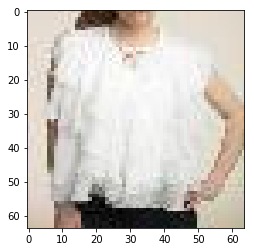

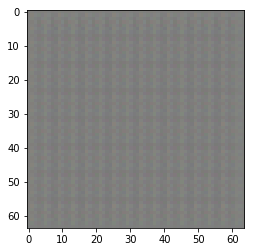

In [9]:
cur_x, cur_y = train_dataset.next_batch(2)
test_image = sess.run([gen], feed_dict={x:cur_x, y:cur_y})


show_image(cur_x[1])
test_image = np.array(test_image)
show_image(np.squeeze(test_image)[1])



In [15]:
test_image = np.array(test_image)
print(test_image)
show_image(np.squeeze(test_image)[0])

[[[[[ 0.01731281 -0.00049786 -0.00051697]
    [ 0.0268098  -0.02541385  0.01045074]
    [ 0.02335242 -0.00472535  0.000988  ]
    ..., 
    [ 0.02309056 -0.0233418   0.00030125]
    [ 0.01858981 -0.00071221 -0.00074584]
    [ 0.00630514 -0.00156878 -0.00217882]]

   [[ 0.01544815 -0.00251214  0.00103776]
    [ 0.02088345  0.0127382  -0.02702123]
    [ 0.02707589  0.04212866 -0.0209272 ]
    ..., 
    [ 0.01083681  0.00754928 -0.02845698]
    [ 0.02097915  0.04105031 -0.02113053]
    [ 0.02737332  0.0151865   0.0047413 ]]

   [[ 0.02455161 -0.00475989 -0.01290123]
    [ 0.04648749 -0.00521686 -0.00242949]
    [ 0.02918772  0.04352136  0.00890721]
    ..., 
    [ 0.04670377  0.00393848 -0.01058939]
    [ 0.01506993  0.04881216  0.00720783]
    [ 0.00852257 -0.00583907  0.00246301]]

   ..., 
   [[ 0.02219488  0.00472032  0.00305387]
    [ 0.01431249  0.00610014 -0.02272281]
    [ 0.03196518  0.03460883 -0.02070677]
    ..., 
    [ 0.01392783  0.00794118 -0.02172735]
    [ 0.02281539  0.0

ValueError: Floating point image RGB values must be in the 0..1 range.

In [ ]:
with tf.Session(config=config) as sess:
    for epoch in range(n_iters):
        cls_cost = sess,run([cls_optimizer], feed_dict={x:dataset.nextbatch(), y:label.nextbatch()})
        print('classifer loss: %f, accuracy: %f' % (cls_cost, accuracy.eval()))
    saver.save(sess, 'save/to/path')
        